In [1]:
import torchvision
import urllib.request
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy

In [2]:
# Load a pre-trained FasterRCNN neural net with a MobileNetV3 backbone
weights = torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
fasterrcnn = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    weights=weights, box_score_thresh=0.2)
fasterrcnn.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [3]:
# Create the transform pipeline and the list of categories
transform = weights.transforms()
categories = weights.meta["categories"]

In [4]:
# Select a list of image URLs
image_url_list = ["https://live.staticflickr.com/4097/4853532309_fb9e07c982_z.jpg",
                 "https://live.staticflickr.com/3734/20155251085_e8fcf98acc_z.jpg",
                 "https://live.staticflickr.com/5244/5686921967_87f9fb9348_z.jpg"]

In [5]:
# Build a list of image tensors, and a list of original images
batch_list = []
original_imgs = []
for img_ndx in range(len(image_url_list)):
    with urllib.request.urlopen(image_url_list[img_ndx]) as url:
        image_pil = Image.open(url)
        image_arr = np.array(image_pil)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_RGB2BGR)
        original_imgs.append(image_arr)
        batch_list.append(transform(image_pil))

In [6]:
# Pass the batch of image tensors through the Faster-RCNN neural network
batch_results = fasterrcnn(batch_list)
print(f"batch_results: \n{batch_results}")

batch_results: 
[{'boxes': tensor([[ 69.2205,  63.1868, 459.6442, 447.0788],
        [ 63.9401, 109.1797, 427.9377, 453.7008]], grad_fn=<StackBackward0>), 'labels': tensor([18, 19]), 'scores': tensor([0.9876, 0.2370], grad_fn=<IndexBackward0>)}, {'boxes': tensor([[ 15.8887,  11.9377, 485.4323, 508.9775],
        [431.0747, 241.0989, 560.5450, 355.8331]], grad_fn=<StackBackward0>), 'labels': tensor([19, 19]), 'scores': tensor([0.9978, 0.9728], grad_fn=<IndexBackward0>)}, {'boxes': tensor([[1.4779e+02, 2.4640e+02, 2.9108e+02, 4.6573e+02],
        [3.8378e+02, 2.9122e+02, 4.8159e+02, 3.2818e+02],
        [3.7900e+02, 2.0346e+02, 4.7190e+02, 2.7578e+02],
        [4.7856e+02, 1.9333e+02, 5.9604e+02, 3.0081e+02],
        [1.6186e+02, 2.6034e+02, 2.1793e+02, 2.7953e+02],
        [1.0426e+02, 1.7993e+02, 2.1503e+02, 2.6473e+02],
        [1.0360e+02, 1.8293e+02, 2.2067e+02, 2.7246e+02],
        [4.8483e+02, 3.1527e+02, 6.0181e+02, 3.8093e+02],
        [2.5482e+01, 3.1731e+02, 1.2303e+02, 4.2522

In [7]:
# Define a function that returns a random color
def random_color(index):
    color = ((index * 371)%256, (index * 1169)%256, (index * 947)%256)
    if color == (0, 0, 0):
        color = (200, 0, 0)
    return color

In [8]:
# Annotate the images
annotated_imgs = []
for img_ndx in range(len(batch_results)):
    labels = [categories[i] for i in batch_results[img_ndx]["labels"]]
    number_of_boxes = len(labels)
    annotated_img = copy.deepcopy(original_imgs[img_ndx])
    for box_ndx in range(number_of_boxes):
        roi_x1y1_x2y2 = batch_results[img_ndx]["boxes"][box_ndx].int().numpy()
        p1 = (roi_x1y1_x2y2[0], roi_x1y1_x2y2[1])
        p2 = (roi_x1y1_x2y2[2], roi_x1y1_x2y2[3])
        color = random_color(box_ndx)
        cv2.rectangle(annotated_img, p1, p2, color=color, thickness=2)
        cv2.putText(annotated_img, labels[box_ndx], p1, cv2.FONT_HERSHEY_SIMPLEX,
                    1.0, color=(0, 0, 0), thickness=3)
        cv2.putText(annotated_img, labels[box_ndx], p1, cv2.FONT_HERSHEY_SIMPLEX,
                    1.0, color=color, thickness=1)
    annotated_imgs.append(annotated_img)

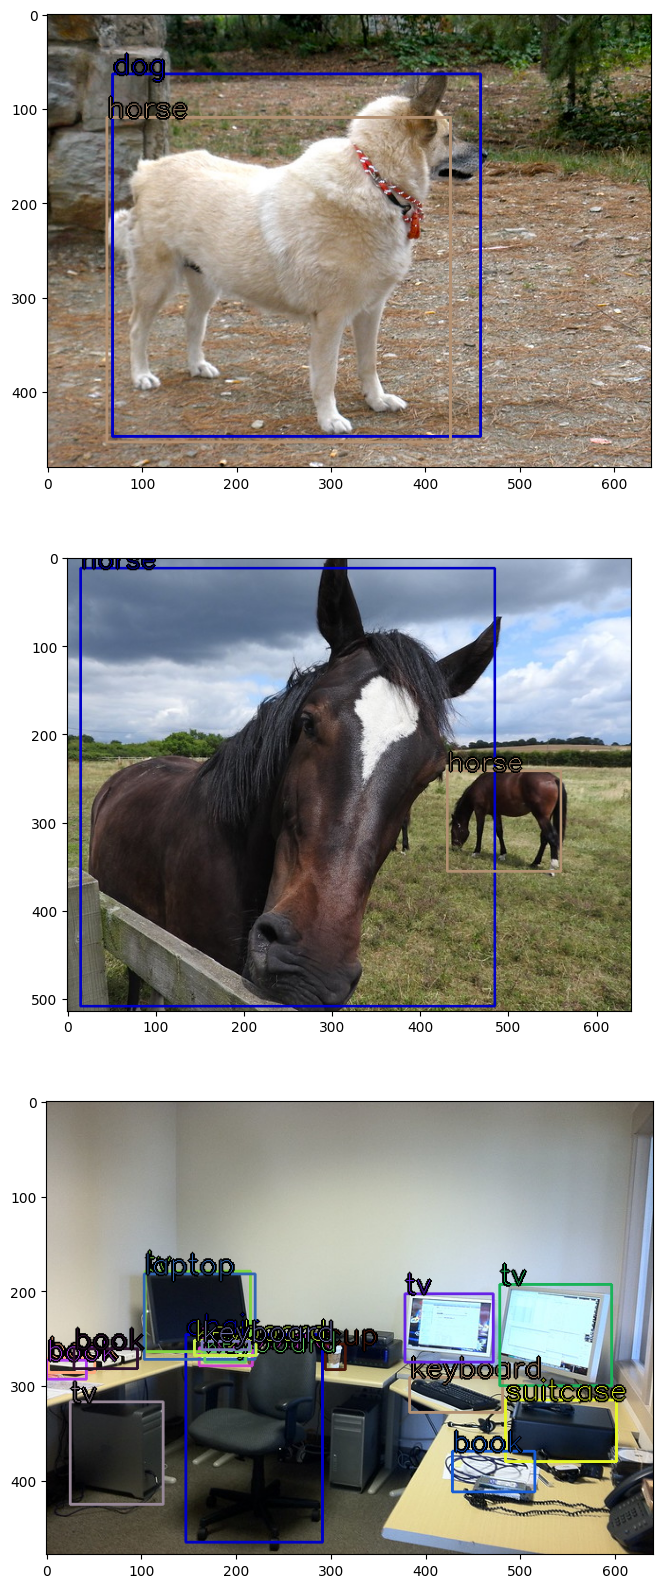

In [9]:
# Display the annotated images
# Don't forget to convert the image from BGR to RGB, as matplotlib expects RGB images
if len(annotated_imgs) == 1:
    fig, axs = plt.subplots(figsize=(40, 20))
    axs.imshow(cv2.cvtColor(annotated_imgs[img_ndx], cv2.COLOR_RGB2BGR))
elif len(annotated_imgs) > 1:
    fig, axs = plt.subplots(len(annotated_imgs), figsize=(40, 20))
    for img_ndx in range(len(annotated_imgs)):
        axs[img_ndx].imshow(cv2.cvtColor(annotated_imgs[img_ndx], cv2.COLOR_RGB2BGR))

In [10]:
# Filter the found objects with a minimum score
minimum_score = 0.8
annotated_imgs = []
for img_ndx in range(len(batch_results)):
    labels = [categories[i] for i in batch_results[img_ndx]["labels"]]
    number_of_boxes = len(labels)
    annotated_img = copy.deepcopy(original_imgs[img_ndx])
    for box_ndx in range(number_of_boxes):
        score = batch_results[img_ndx]["scores"][box_ndx]
        if score >= minimum_score:
            roi_x1y1_x2y2 = batch_results[img_ndx]["boxes"][box_ndx].int().numpy()
            p1 = (roi_x1y1_x2y2[0], roi_x1y1_x2y2[1])
            p2 = (roi_x1y1_x2y2[2], roi_x1y1_x2y2[3])
            color = random_color(box_ndx)
            cv2.rectangle(annotated_img, p1, p2, color=color, thickness=2)
            cv2.putText(annotated_img, labels[box_ndx], p1, cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, color=(0, 0, 0), thickness=3)
            cv2.putText(annotated_img, labels[box_ndx], p1, cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, color=color, thickness=1)
    annotated_imgs.append(annotated_img)

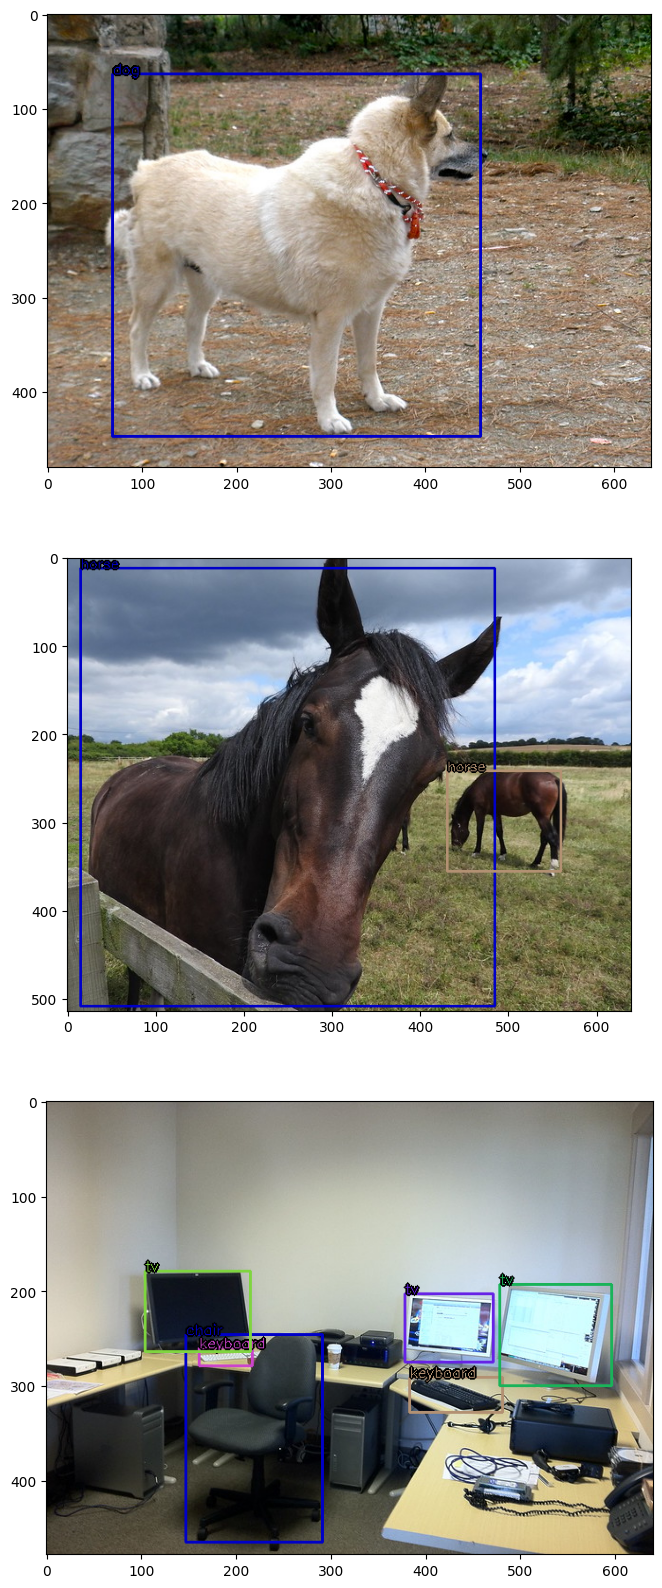

In [11]:
# Display the annotated images
if len(annotated_imgs) == 1:
    fig, axs = plt.subplots(figsize=(40, 20))
    axs.imshow(cv2.cvtColor(annotated_imgs[img_ndx], cv2.COLOR_RGB2BGR))
elif len(annotated_imgs) > 1:
    fig, axs = plt.subplots(len(annotated_imgs), figsize=(40, 20))
    for img_ndx in range(len(annotated_imgs)):
        axs[img_ndx].imshow(cv2.cvtColor(annotated_imgs[img_ndx], cv2.COLOR_RGB2BGR))